In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import seaborn as sns
import anndata
import string
import gc
from anndata import read_h5ad
from anndata import read_csv
from pandas import DataFrame
import h5py
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import networkx as nx
import plotly.graph_objects as go
from scipy.stats import spearmanr
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster
import pickle 

/home/anton.thieme/miniconda3/envs/sc_env/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)


## LOAD DATA

In [2]:
adata_tf = read_h5ad(os.path.join('..', 'data', 'adata_tf.h5ad'))
adata_tf

AnnData object with n_obs × n_vars = 1093048 × 1637
    obs: 'donor', 'tissue', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'old_index', 'assay', 'sample_id', 'replicate', '10X_run', '10X_barcode', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_ontology_class', 'cell_ontology_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'age', 'sex', 'ethnicity', 'sample_number'
    var: 'ensembl_id', 'gene_symbol', 'genome', 'mt', 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', '_training_mode', 'age_colors', 'assay_colors', 'compartment_colors', 'donor_colors', 'leiden', 'log1p', 'method_colors

In [3]:
# Step 1: Extract the gene expression matrix
# Assuming adata.X is sparse; convert to dense
X = adata_tf.X.toarray()  # Converts to dense (use .A for CSR matrices)

In [4]:
# Assign gene names as row/column labels if available
gene_names = adata_tf.var.index.tolist()  # List of gene names

## FILTER OUT GENES WITH ZERO VARIANCE

In [5]:
# Identify genes with zero variance
gene_variance = np.var(X, axis=0)
non_constant_genes = gene_variance > 0
print(X.shape)
print(len(non_constant_genes))

# Filter matrix
X_filtered = X[:, non_constant_genes]
gene_names_filtered = np.array(gene_names)[non_constant_genes]
print(X_filtered.shape)

(1093048, 1637)
1637
(1093048, 1635)


## CALCULATE PAIRWISE CORRELATION WITHIN EACH CELL TYPE

In [6]:
adata_tf.obs.cell_ontology_class.unique()

['macrophage', 'mesenchymal stem cell of adipose tissue', 'mast cell', 'neutrophil', 'fibroblast', ..., 'kidney epithelial cell', 'retinal pigment epithelial cell', 'keratinocyte', 'enterocyte of epithelium proper of jejunum', 'leukocyte']
Length: 175
Categories (175, object): ['acinar cell', 'acinar cell of salivary gland', 'activated cd4-positive, alpha-beta t cell', 'activated cd8-positive, alpha-beta t cell', ..., 'vascular associated smooth muscle cell', 'vein endothelial cell', 'ventricular cardiac muscle cell', 'vestibular dark cell']

In [ ]:
# Step 1: Group cells by cell type
cell_types = adata_tf.obs['cell_ontology_class'].unique()

# Step 2: Initialize a dictionary to store results
correlation_matrices = {}

# Step 3: Loop through each cell type
for cell_type in cell_types:
    # Subset AnnData object for the current cell type
    cell_type_data = adata_tf[adata_tf.obs['cell_ontology_class'] == cell_type]
    
    # Step 4: Compute Spearman's rho
    spearman_corr_matrix, _ = spearmanr(X_filtered, axis=0)
    
    # Store the correlation matrix in the dictionary
    correlation_matrices[cell_type] = spearman_corr_matrix

    # Print progress
    print(f"Computed correlation for cell type: {cell_type}")

# Step 5: Access results
print(f"Available cell types: {list(correlation_matrices.keys())}")
print(f"Correlation matrix for first cell type:\n{correlation_matrices[cell_types[0]]}")

Computed correlation for cell type: macrophage
Computed correlation for cell type: mesenchymal stem cell of adipose tissue
Computed correlation for cell type: mast cell
Computed correlation for cell type: neutrophil
Computed correlation for cell type: fibroblast
Computed correlation for cell type: cd8-positive, alpha-beta t cell
Computed correlation for cell type: monocyte
Computed correlation for cell type: cd4-positive, alpha-beta t cell
Computed correlation for cell type: pericyte
Computed correlation for cell type: endothelial cell
Computed correlation for cell type: erythrocyte
Computed correlation for cell type: intermediate monocyte
Computed correlation for cell type: thymic fibroblast type 1
Computed correlation for cell type: thymic fibroblast type 2
Computed correlation for cell type: natural killer cell


In [ ]:
save_path = os.path.join('..', 'data', 'correlation_matrices.pkl')
with open(save_path, 'wb') as f:
    pickle.dump(correlation_matrices, f)

In [ ]:
correlation_matrices['pericyte']

/hpc/user_apps/data.science/conda_envs/single-cell-base/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


ValueError: The condensed distance matrix must contain only finite values.

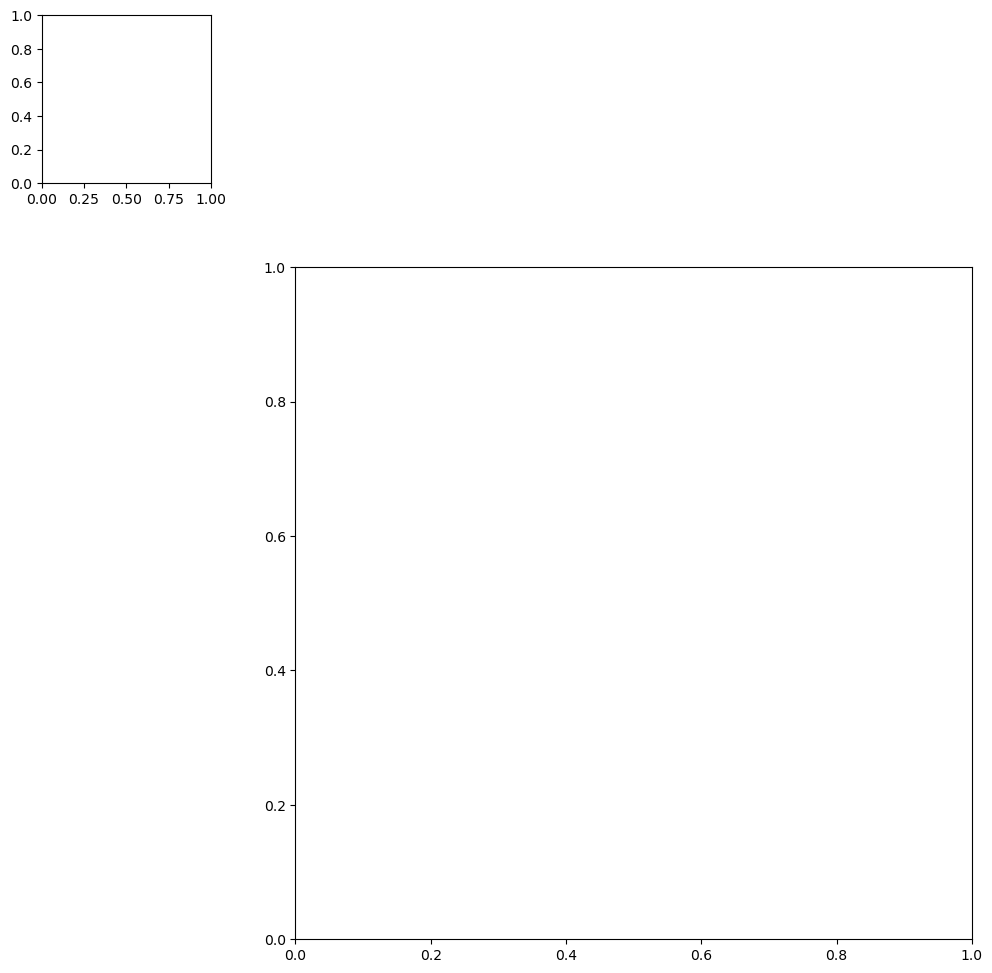

In [17]:
clustermap = sns.clustermap(
    correlation_matrices['pericyte'],  # The gene-gene correlation matrix
    method='average',      # Linkage method (e.g., single, complete, average)
    metric='correlation',    # Distance metric (e.g., euclidean, correlation)
    cmap='coolwarm',
    figsize=(12, 12)
)
plt.title("Clustered Gene-Gene Correlation Heatmap")
plt.show()

In [16]:
correlation_matrices

{'macrophage': array([[ 1.00000000e+00,  1.00912950e-02,  5.81908949e-03, ...,
          3.66608299e-02,  1.23680268e-02,  1.38369129e-03],
        [ 1.00912950e-02,  1.00000000e+00, -7.86089322e-04, ...,
         -2.89160494e-03,  4.68465885e-03, -1.16469259e-03],
        [ 5.81908949e-03, -7.86089322e-04,  1.00000000e+00, ...,
          1.36480645e-02,  3.93935863e-03, -1.26928011e-03],
        ...,
        [ 3.66608299e-02, -2.89160494e-03,  1.36480645e-02, ...,
          1.00000000e+00,  7.61804377e-03,  7.70883299e-03],
        [ 1.23680268e-02,  4.68465885e-03,  3.93935863e-03, ...,
          7.61804377e-03,  1.00000000e+00, -3.53668867e-03],
        [ 1.38369129e-03, -1.16469259e-03, -1.26928011e-03, ...,
          7.70883299e-03, -3.53668867e-03,  1.00000000e+00]]),
 'mesenchymal stem cell of adipose tissue': nan,
 'mast cell': nan,
 'neutrophil': array([[ 1.00000000e+00, -1.96616651e-03, -3.93242012e-03, ...,
          9.53111059e-03, -1.59804301e-03, -7.92427248e-06],
       